In [51]:
import numpy as np 
import pandas as pd
import os

In [52]:
train_df = pd.read_csv("train_dt.csv")

In [53]:
train_df.head().T

,0,1,2,3,4
Loan_ID,LP001002,LP001003,LP001005,LP001006,LP001008
Gender,Male,Male,Male,Male,Male
Married,No,Yes,Yes,Yes,No
Dependents,0,1,0,0,0
Education,Graduate,Graduate,Graduate,Not Graduate,Graduate
Self_Employed,No,No,Yes,No,No
ApplicantIncome,5849,4583,3000,2583,6000
CoapplicantIncome,0.0,1508.0,0.0,2358.0,0.0
LoanAmount,NaN,128.0,66.0,120.0,141.0
Loan_Amount_Term,360.0,360.0,360.0,360.0,360.0


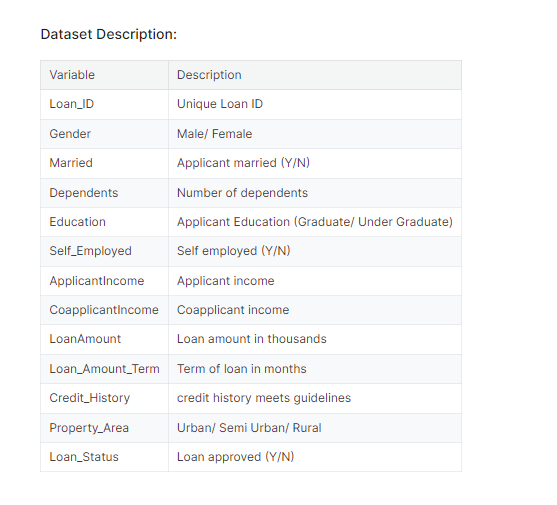

# Exploratory Data Analysis

In [54]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


### Check for missing data

In [55]:
train_df.isna().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [56]:
train_df.dropna(inplace=True)

In [57]:
train_df.isna().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

- All missing data has been removed

### Check for Duplicates

In [58]:
train_df.duplicated().sum()

0

### Understand Relation between input variables and target variables

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

### Check Relation Between Gender and Loan Status

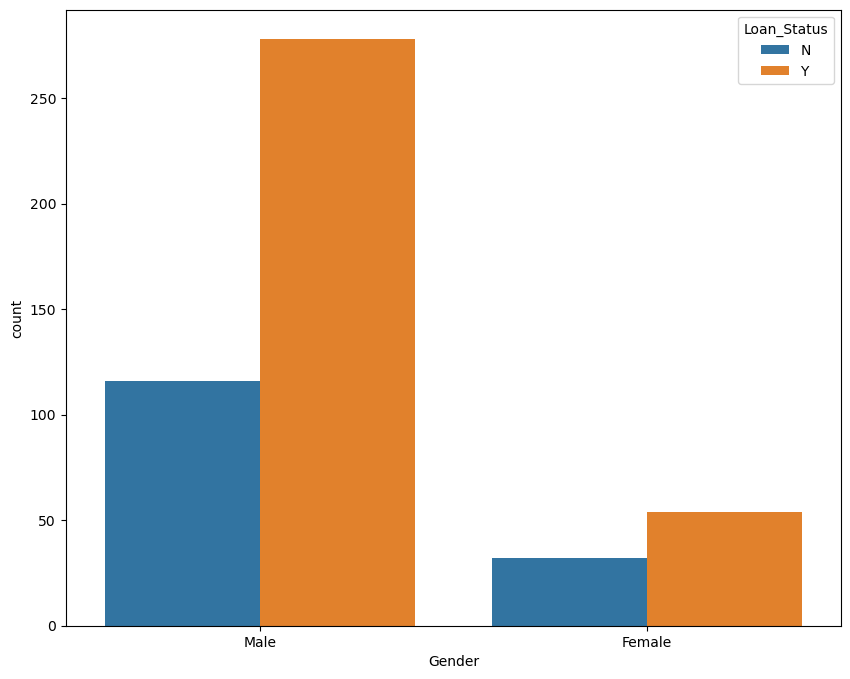

In [60]:
plt.subplots(figsize=(10,8))
sns.countplot(x=train_df['Gender'], hue = train_df['Loan_Status'])
plt.show()

In [61]:
df_gender_summ = train_df.groupby(['Gender', 'Loan_Status']).agg(loan_approved_count = ('Loan_Status', 'count')).reset_index()
df_gender_summ

,Gender,Loan_Status,loan_approved_count
0,Female,N,32
1,Female,Y,54
2,Male,N,116
3,Male,Y,278


In [62]:
df_appl_summ = train_df.groupby(['Gender']).agg(loan_approved_count = ('Loan_Status', 'count')).reset_index()
df_appl_summ

,Gender,loan_approved_count
0,Female,86
1,Male,394


In [63]:
# Merge both

df_summ = df_appl_summ.merge(df_gender_summ, how='left', on='Gender')
df_summ

,Gender,loan_approved_count_x,Loan_Status,loan_approved_count_y
0,Female,86,N,32
1,Female,86,Y,54
2,Male,394,N,116
3,Male,394,Y,278


In [64]:
df_summ['% Status'] = round((100*df_summ['loan_approved_count_y']/df_summ['loan_approved_count_x']),2)
df_summ

,Gender,loan_approved_count_x,Loan_Status,loan_approved_count_y,% Status
0,Female,86,N,32,37.21
1,Female,86,Y,54,62.79
2,Male,394,N,116,29.44
3,Male,394,Y,278,70.56


- Rejection rate is higher in Female by almost 8% as compared to Male

### Relationship between 'Income' and Loan Approval Rate

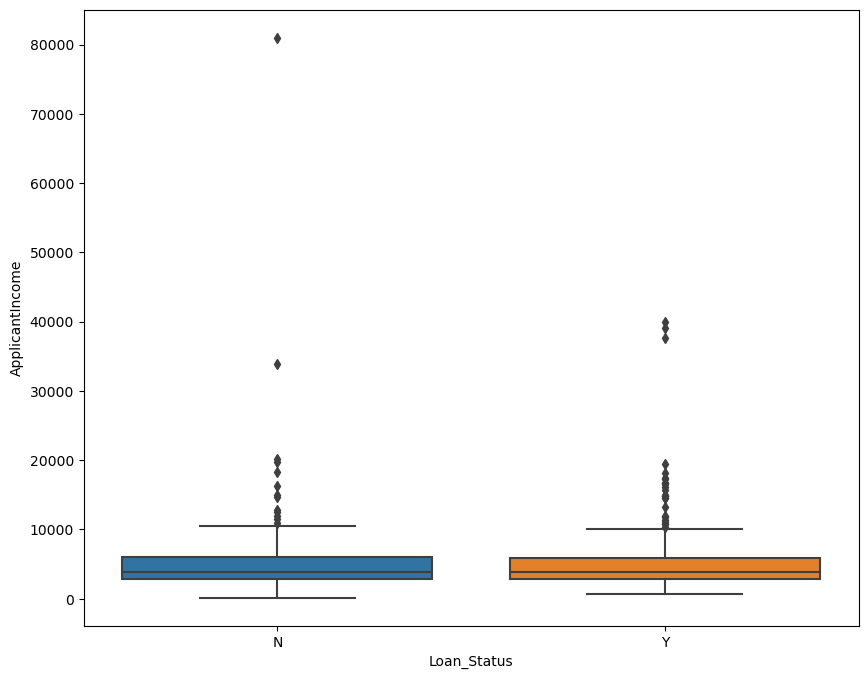

In [65]:
plt.figure(figsize = (10,8))
sns.boxplot(x = train_df['Loan_Status'], y = train_df['ApplicantIncome'])
plt.show()

In [66]:
train_df['ApplicantIncome'].describe()

count      480.000000
mean      5364.231250
std       5668.251251
min        150.000000
25%       2898.750000
50%       3859.000000
75%       5852.500000
max      81000.000000
Name: ApplicantIncome, dtype: float64

- Applicant income is highly volatile which basically means that has a lot of variability since standard deviation ~ average applicant's income (5300 USD)

C:\Users\jadha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


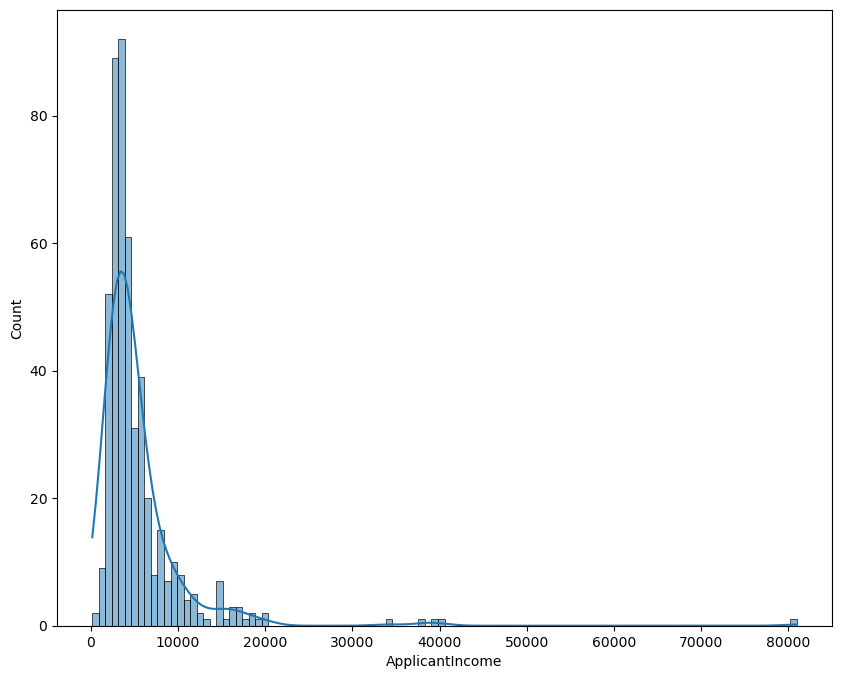

In [67]:
plt.figure(figsize = (10,8))
sns.histplot(train_df['ApplicantIncome'], kde=True)
plt.show()

In [68]:
sel_income = train_df['ApplicantIncome']<=12000

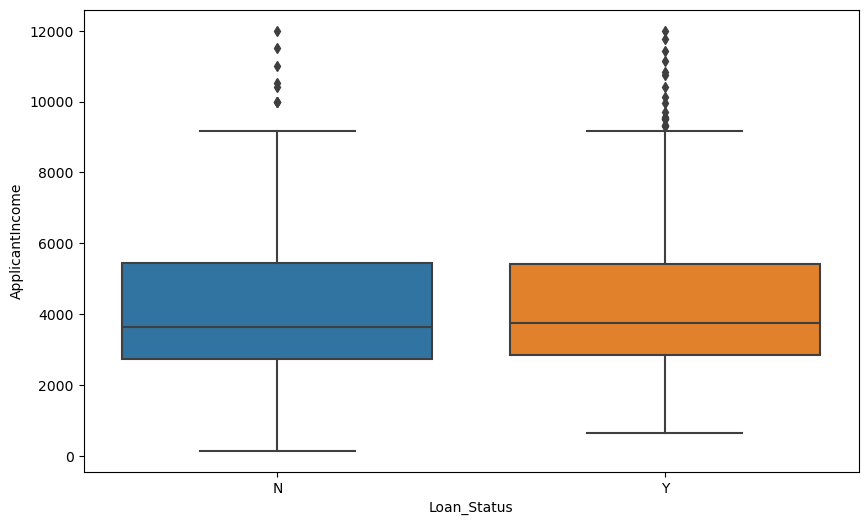

In [69]:
plt.figure(figsize = (10,6))
sns.boxplot(x=train_df[sel_income]['Loan_Status'], y=train_df[sel_income]['ApplicantIncome'])
plt.show()

- Key takeaway: Looking at boxplot after excluding extreme outliers, it seems that applicant income has not much impact on loan approval status

### Relationship between Loan Amount and Loan Status

C:\Users\jadha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


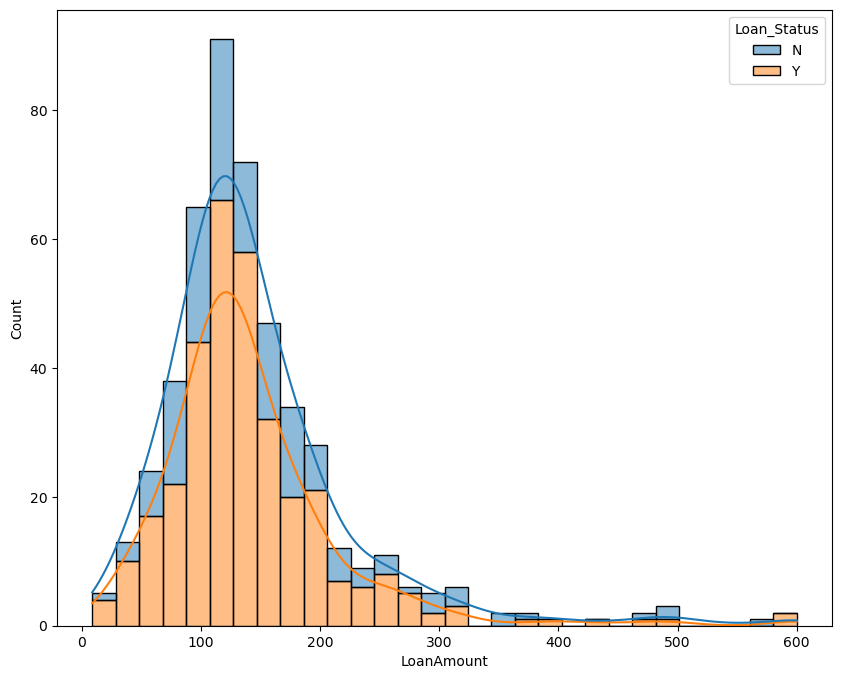

In [70]:
plt.figure(figsize = (10,8))
sns.histplot(data = train_df, x = 'LoanAmount', hue='Loan_Status', multiple='stack', kde=True, bins=30)
plt.show()

- It's a mixed observation if loan amount has impact on loan status

### Relationship between Property Type and Loan Status

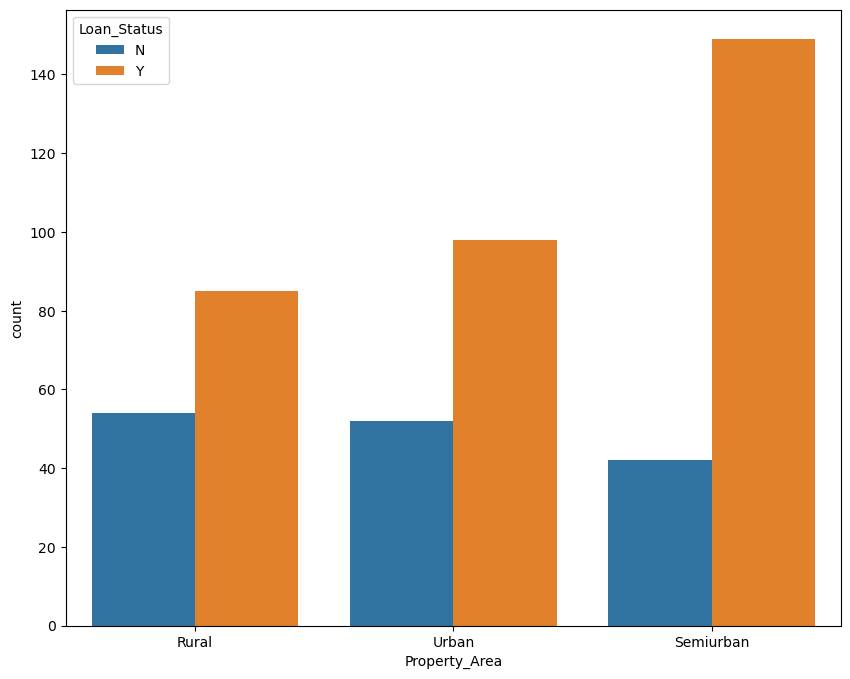

In [71]:
plt.subplots(figsize=(10,8))
sns.countplot(x=train_df['Property_Area'], hue = train_df['Loan_Status'])
plt.show()

- Rural properties are getting the least no. of loan approvals
- Semi-urban properties are getting the highest no. of loan approvals

### Relationship between Self Employed and Loan Status

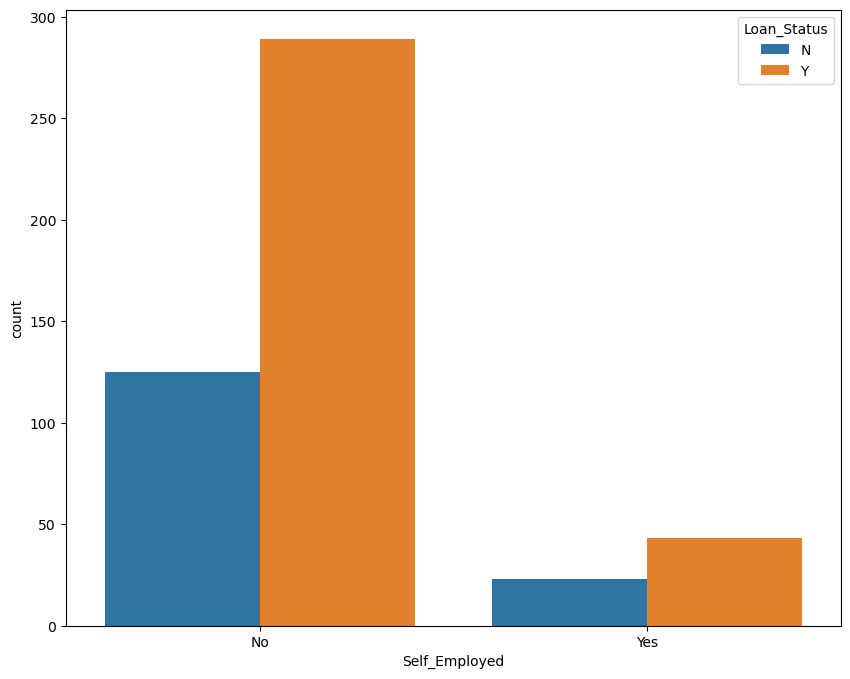

In [72]:
plt.subplots(figsize = (10,8))
sns.countplot(x = train_df['Self_Employed'], hue=train_df['Loan_Status'])
plt.show()

- Number of loan applicants and the loan approval rate is low for self employed

### Correlation Matrix

In [78]:
cor = train_df.corr(numeric_only =True)
cor

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
ApplicantIncome,1.000000,-0.112588,0.495310,-0.010838,-0.056152
CoapplicantIncome,-0.112588,1.000000,0.190740,-0.005775,-0.008692
LoanAmount,0.495310,0.190740,1.000000,0.050867,-0.040773
Loan_Amount_Term,-0.010838,-0.005775,0.050867,1.000000,0.032937
Credit_History,-0.056152,-0.008692,-0.040773,0.032937,1.000000


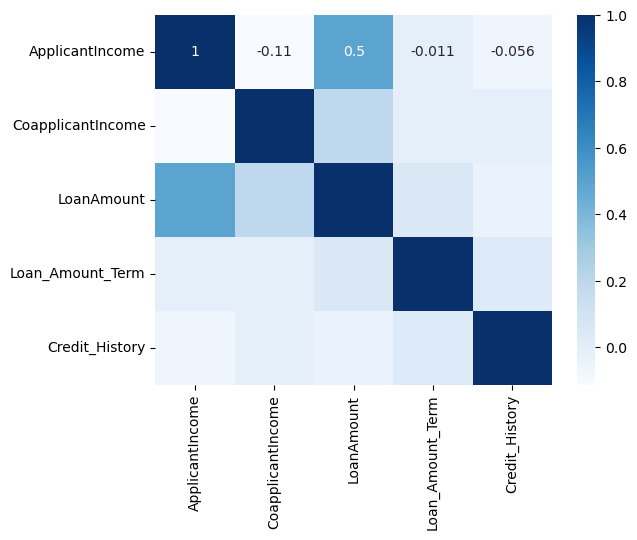

In [79]:
sns.heatmap(cor, annot=True, cmap='Blues')
plt.show()

- Input variables seem to be not correlated much which is showing no signs of multicollinearity
- Correlation value between -0.3 and 0.3 ==> weak correlation
- Key takeaway: Applicant incomes seems to be moderately correlated with the loan amount

In [80]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 480 entries, 1 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            480 non-null    object 
 1   Gender             480 non-null    object 
 2   Married            480 non-null    object 
 3   Dependents         480 non-null    object 
 4   Education          480 non-null    object 
 5   Self_Employed      480 non-null    object 
 6   ApplicantIncome    480 non-null    int64  
 7   CoapplicantIncome  480 non-null    float64
 8   LoanAmount         480 non-null    float64
 9   Loan_Amount_Term   480 non-null    float64
 10  Credit_History     480 non-null    float64
 11  Property_Area      480 non-null    object 
 12  Loan_Status        480 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 52.5+ KB


### Encoding Categorical Features

In [81]:
train_df.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [82]:
sel_cols =  ['Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area']

In [83]:
train_df_encoded = pd.get_dummies(train_df[sel_cols], drop_first=True)

## Train test split

In [87]:
from sklearn.model_selection import train_test_split  #training and testing dataset split
from sklearn.preprocessing import StandardScaler  #standardizing the data z= (X - Mean)/sigma
from sklearn.tree import DecisionTreeClassifier


In [88]:
X = train_df_encoded

In [89]:
train_df['Target'] = train_df['Loan_Status'].replace({'Y':1, 'N':0})

In [91]:
y = train_df['Target']

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [93]:
X_train.shape

(384, 14)

In [94]:
X_test.shape

(96, 14)

### Build the DT Model - 1

In [95]:
tree_mdl_1 = DecisionTreeClassifier()

#### Train the decision tree model on Loan approval data

In [97]:
tree_mdl_1.fit(X_train, y_train)

DecisionTreeClassifier()

#### Predict the validation (test) data

In [99]:
pred_values = tree_mdl_1.predict(X_test)

### Performance Matrix

In [101]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

In [102]:
print('Validation Accuracy:', accuracy_score(pred_values, y_test)*100)

Validation Accuracy: 72.91666666666666


#### Plot the confusion matrix

In [103]:
cm = confusion_matrix(pred_values, y_test)
cm

array([[17, 15],
       [11, 53]], dtype=int64)

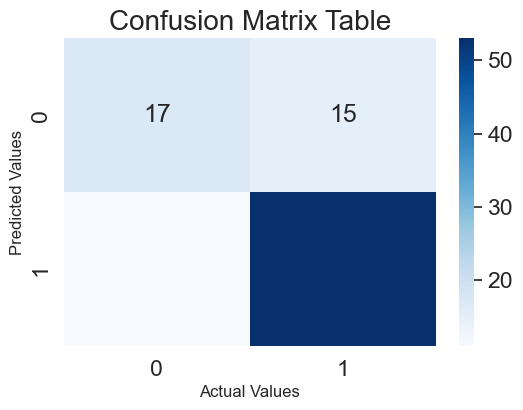

In [106]:
plt.subplots(figsize=(6,4))
sns.set(font_scale=1.5)
sns.heatmap(cm,annot = True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix Table', fontsize=20)
plt.xlabel('Actual Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.show()

In [107]:
from sklearn.metrics import classification_report

In [113]:
clf_report = classification_report(pred_values, y_test)


In [114]:
print(clf_report)

              precision    recall  f1-score   support

           0       0.61      0.53      0.57        32
           1       0.78      0.83      0.80        64

    accuracy                           0.73        96
   macro avg       0.69      0.68      0.68        96
weighted avg       0.72      0.73      0.72        96

